In [1]:
import optuna

study = optuna.load_study(
    study_name="lgbm_study",
    storage="sqlite:///optuna_lgbm.db"
)
print("✅ Study 로드 완료")

C:\Users\tori\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Study 로드 완료


In [2]:
import pandas as pd

df = study.trials_dataframe()
print("전체 trial 수:", len(df))
df.head()

전체 trial 수: 1001


,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,state
0,0,NaN,2025-07-23 17:44:09.310662,2025-07-23 17:44:10.846095,0 days 00:00:01.535433,0.917247,7,0.803184,0.186596,12,71,23,0.858177,2.947761,FAIL
1,1,0.026144,2025-07-23 17:48:39.551351,2025-07-23 17:48:41.044172,0 days 00:00:01.492821,0.937999,3,0.881995,0.124368,7,91,126,3.714990,2.628565,COMPLETE
2,2,0.014706,2025-07-23 17:48:41.076013,2025-07-23 17:48:42.381878,0 days 00:00:01.305865,0.857805,8,0.953391,0.107057,11,68,58,0.131932,3.403680,COMPLETE
3,3,0.021242,2025-07-23 17:48:42.406338,2025-07-23 17:48:42.575196,0 days 00:00:00.168858,0.703774,6,0.822954,0.216099,11,77,86,3.741054,2.812572,COMPLETE
4,4,0.019608,2025-07-23 17:48:42.598532,2025-07-23 17:48:42.778155,0 days 00:00:00.179623,0.912843,6,0.665077,0.126253,7,33,66,3.551268,3.152901,COMPLETE


In [3]:
df["accuracy"] = 1.0 - df["value"]
df_sorted = df.sort_values("accuracy", ascending=False)
df_sorted.head(5)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_learning_rate,params_max_depth,params_min_child_samples,params_num_leaves,params_reg_alpha,params_reg_lambda,state,accuracy
856,856,0.013072,2025-07-23 17:56:04.088334,2025-07-23 17:56:04.596983,0 days 00:00:00.508649,0.809968,6,0.774332,0.146834,9,21,100,0.565154,3.066072,COMPLETE,0.986928
858,858,0.013072,2025-07-23 17:56:05.096561,2025-07-23 17:56:05.536957,0 days 00:00:00.440396,0.830096,6,0.927274,0.155342,10,29,89,0.394207,2.865588,COMPLETE,0.986928
868,868,0.013072,2025-07-23 17:56:10.074361,2025-07-23 17:56:10.674365,0 days 00:00:00.600004,0.763092,7,0.775494,0.104120,9,35,54,0.176911,2.229711,COMPLETE,0.986928
869,869,0.013072,2025-07-23 17:56:10.703119,2025-07-23 17:56:11.144485,0 days 00:00:00.441366,0.781646,6,0.806999,0.132355,9,50,125,0.385780,2.037170,COMPLETE,0.986928
839,839,0.013072,2025-07-23 17:55:55.101388,2025-07-23 17:55:55.528463,0 days 00:00:00.427075,0.804923,6,0.921690,0.127326,8,33,118,0.658468,2.763377,COMPLETE,0.986928


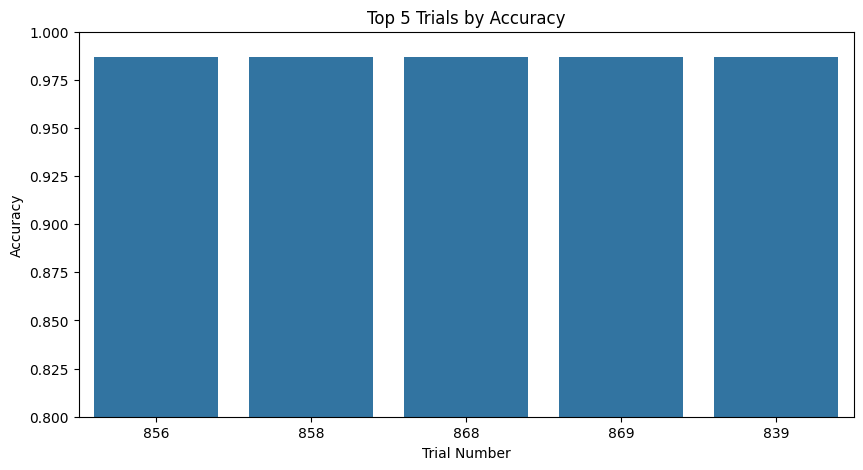

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

top5 = df_sorted.head()
plt.figure(figsize=(10, 5))
sns.barplot(x=top5["number"].astype(str), y=top5["accuracy"])
plt.title("Top 5 Trials by Accuracy")
plt.xlabel("Trial Number")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.show()

In [5]:
# 📊 간이 파라미터 중요도 분석 (정확도와 상관관계)
param_cols = [c for c in df.columns if c.startswith("params_")]
correlations = df[param_cols + ["accuracy"]].corr()["accuracy"].drop("accuracy").sort_values(key=abs, ascending=False)
correlations.to_frame("Pearson Correlation with Accuracy")

,Pearson Correlation with Accuracy
params_reg_alpha,-0.661574
params_max_depth,0.149476
params_min_child_samples,-0.109919
params_num_leaves,0.098108
params_reg_lambda,-0.061035
params_feature_fraction,-0.056328
params_learning_rate,-0.053373
params_bagging_freq,0.052554
params_bagging_fraction,-0.042761


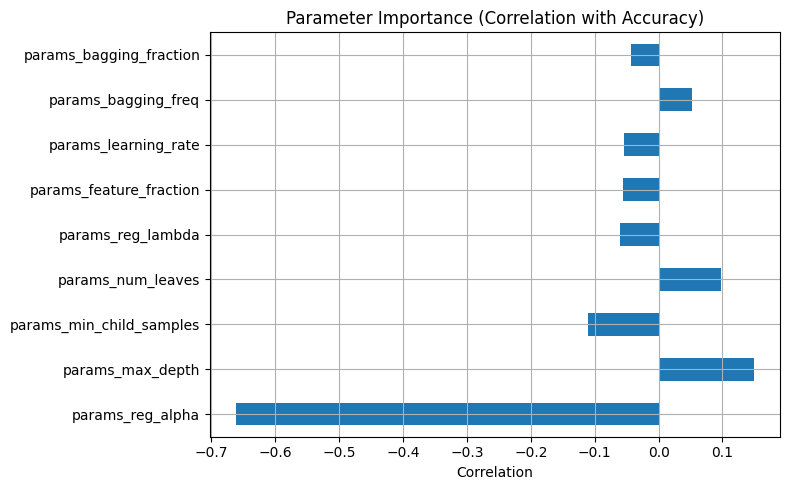

In [6]:
plt.figure(figsize=(8, 5))
correlations.plot(kind="barh")
plt.title("Parameter Importance (Correlation with Accuracy)")
plt.xlabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

params_reg_alpha = -0.68
→ L1 정규화 값이 클수록 정확도는 분명히 낮아지는 경향이 있음

💡 이는 일반적인 LightGBM 경향과도 맞습니다:

너무 강한 정규화는 모델 표현력을 억제해서 underfitting 유도

params_max_depth ≈ +0.08
→ 모델이 더 깊어질수록 (트리가 깊을수록) 약간 더 정확도가 올라가는 경향 있음

params_min_child_samples ≈ -0.1
→ 하나의 leaf에 들어가는 최소 샘플 수가 커질수록 정확도는 떨어질 수 있음
(즉, leaf의 분할이 너무 억제되면 복잡한 패턴을 못 잡음)